# Preprocessing and augmentation
In this notebook we'll look at different ways of sound-specific data preprocessing and augmenting our data.

In terms of preprocessing we will be turning our raw .wav files into:<br/>
<br/>
MFCC<br/>
Mel spectrogram<br/>
FFT<br/>
Tempogram<br/>

In terms of augmentation we will try adding background noise from the "silence" files provided by the Google Brain team and making small alterations to the .wav files themselves. The latter is similar to adding a small rotation to an image in image preprocessing. 

The goal is to get a more diverse / larger training set. We've already experimented with turning our .wav files into images (spectrograms and chromagrams) in the previous notebook and that is also, arguably, a form of preprocessing. 

In the next notebook we will use the preprocessing & augmentation methods outlined here to create new sample subsets of our data and we'll test simple models on them, in order to figure out which types of preprocessing are most promising.

In [4]:
# first make sure we're in the parent dictory of our data/sample folders.
!pwd

/home/paperspace/tensorflow_speech_recognition


## Import
We'll need a couple of additional libraries so let's import them.

In [5]:
# filter out warnings
import warnings
warnings.filterwarnings('ignore') 

In [29]:
import librosa
import numpy as np
import os
import matplotlib.pyplot as plt

import IPython.display as ipd
from pydub import AudioSegment

# utils
from importlib import reload
import utils; reload(utils)

# audio mixing and augmentation functions from utils.py
from utils import mix_audio, augment_with_white_noise, augment_with_shift

# graphing functions from utils.py
from utils import get_wav_info, display_audio, graph_waveform, graph_multiple_waveforms
from utils import graph_spectrogram, graph_multiple_spectrograms, graph_mel_spectrogram
from utils import graph_waveform_from_data

## Preprocessing
At first we are presented with a raw .wav data and we have already used a function for extracting MFCCs from it. Let's quickly show them in action to get a sense of what we're trying to achieve.

### Raw .wav

In [7]:
# define paths
path_to_sample = "data/sample"
path_to_stop = os.path.join(path_to_sample, "train/stop/012c8314_nohash_0.wav")
path_to_background = os.path.join(path_to_sample, "train/silence/pink_noise_20.wav")

In [14]:
# we are aiming to get differently preprocessed training examples
# which by convention form a matrix called X, where a single row is x
x_raw = utils.get_wav_info(path_to_stop)
x_raw

(16000, array([252., 260., 225., ..., 356., 337., 345.]))

In [26]:
print("Basic type: {}\nVector Length: {}\nColumn type: {}".format(type(x_raw), len(x_raw[1]), type(x_raw[1][0])))

Basic type: <class 'tuple'>
Vector Length: 16000
Column type: <class 'numpy.float64'>


As we can see we start with a raw vector from the .wav file, with 16K columns.

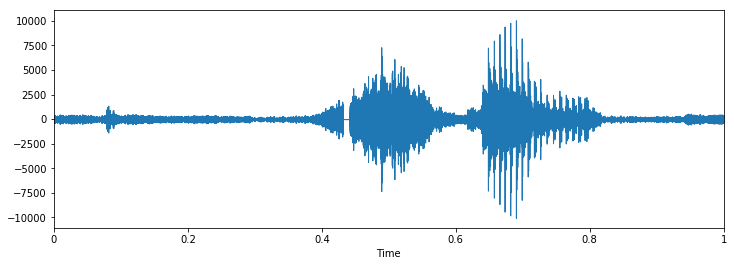

In [25]:
utils.graph_waveform(path_to_stop)

### MFCC
Let's see what we get from the same .wav file when we extract the mel frequency cepstral coefficients.

In [20]:
x_mfccs = utils.extract_mfccs(path_to_stop)
x_mfccs

array([-3.30111106e+02,  4.63385571e+01, -2.62556921e+00,  2.01899943e+01,
       -4.08182689e+00,  1.79362854e+01, -8.55874363e+00,  4.34238802e+00,
       -3.64006472e+00,  1.65247423e+01, -9.46132651e+00,  1.47386812e+01,
       -4.13251890e-01,  6.81944491e+00, -3.37538974e+00,  6.10107127e+00,
       -1.23957973e+01,  1.13487431e+00,  9.32360139e-02,  1.26209478e+01,
       -5.61702888e+00,  7.99690758e+00, -4.12989334e-01,  4.05789274e+00,
        3.33685073e+00,  8.63119578e+00, -1.20470086e+00,  2.02498013e+00,
        9.13529486e-01,  9.06021455e+00,  4.11633405e+00,  6.46763914e+00,
        1.13732447e+00,  7.84342791e-01, -1.39949543e+00,  1.70781812e+00,
        4.75041552e+00,  1.56147241e+00, -3.34381766e-01, -2.55034858e+00])

In [27]:
print("Basic type: {}\nVector Length: {}\nColumn type: {}".format(type(x_mfccs), len(x_mfccs), type(x_mfccs[0])))

Basic type: <class 'numpy.ndarray'>
Vector Length: 40
Column type: <class 'numpy.float64'>


Extracting the MFCCs turns our input vector from 16000 dimensions to only 40. This is a significant improvement if we're just doing experiments and are facing significant computing resources shortage.

### Mel spectrogram

We can use librosa's built-in Mel spectrogram function, feeding it the raw data we got from the .wav (including the sampling rate).

In [30]:
x_mel_spec = librosa.feature.melspectrogram(x_raw[1], x_raw[0])
x_mel_spec

array([[3.00525895e+08, 3.38672412e+08, 2.21657853e+08, ...,
        2.74322352e+08, 4.83435156e+08, 4.52176358e+08],
       [1.13412863e+07, 8.00224557e+06, 1.61863362e+07, ...,
        2.80068155e+07, 3.08130963e+07, 6.61330164e+06],
       [1.13878758e+07, 9.00585723e+06, 1.29994487e+07, ...,
        2.06959099e+07, 1.84620217e+07, 8.38657992e+06],
       ...,
       [1.23224906e+03, 2.13129839e+03, 3.36142006e+04, ...,
        1.31634739e+03, 1.07844075e+03, 1.36709609e+03],
       [2.75722632e+02, 6.24787101e+02, 7.84845073e+03, ...,
        2.81402800e+02, 3.62998798e+02, 1.33155067e+03],
       [9.62237158e+01, 5.65399485e+01, 4.57542300e+02, ...,
        3.44811029e+01, 1.38344782e+02, 1.00446729e+03]])

As we've already seen in the data visualization part the Mel spectrogram is a 2D image, a matrix.

In [35]:
print("Basic type: {}\nMatrix shape: {}\nColumn type: {}".format(type(x_mel_spec), x_mel_spec.shape, type(x_mel_spec[0][0])))

Basic type: <class 'numpy.ndarray'>
Matrix shape: (128, 32)
Column type: <class 'numpy.float64'>


If we settle on using Mel spectrograms for our models with convolutional layers we will have to bear this in mind.

### FFT

### Tempogram

## Augmentation
Now let's try adding a background noise, stretching & shifting our preprocessed sounds.

### Add background noise
The authors of the competition suggest using the provided "silence" category memebers as background noise - we can mix it in with our other .wav files to produce more "realistic" samples. 

We have plenty to choose from - white & pink noise samples, the background sounds of an exercise bike, dishes being done as well as the sound of water running from a tap.

We'll be using the pydub library as it makes this kind of audio mixing very intuitive.

In [8]:
# we will also want a separate temporary directory to store our mixed files
path_to_tmp = os.path.join(path_to_sample, "tmp")
!mkdir $path_to_tmp

We will try to mix a pink noise background file with an example of someone saying "stop". Here's how these files originally sound:

In [9]:
display_audio(path_to_stop)

In [7]:
display_audio(path_to_background)

We can immediately hear that the "stop" recording has much lower volume than the "silence" one, rather ironically. If we mix them together without adjusting the volume we'll get a sound like this one:

In [8]:
# let's mix the two audio files together
sound1 = AudioSegment.from_wav(path_to_stop)
sound2 = AudioSegment.from_wav(path_to_background)

# mix sound2 with sound1, starting at 0ms into sound1)
output = sound1.overlay(sound2, position=0)

# save the result to data\sample\tmp
path_to_mixed = os.path.join(path_to_tmp, "stop_plus_pink_noise.wav")
output.export(path_to_mixed, format="wav")

# delete the open io.BufferedRandom object (interactions between Jupyter and pydub)
del output

In [9]:
display_audio(path_to_mixed)

The pink noise is too loud for us to even make out the person saying "stop". Even if we could get a model that would pick up the "stop" that would be pointless - we don't want a model that can overhear someone in the background saying a command.

Thanks to pydub, adjusting the volume is very simple.

In [10]:
# grab the two files again
sound1 = AudioSegment.from_wav(path_to_stop)
sound2 = AudioSegment.from_wav(path_to_background)

# we need to make sound 2 more quiet
# reduce volume by 20 dB
sound2_20_db_quieter = sound2 - 20

# mix sound2 with sound1, starting at 0ms into sound1)
output = sound1.overlay(sound2_20_db_quieter, position=0)

# save the result
path_to_mixed_quieter = os.path.join(path_to_tmp, "stop_plus_pink_noise_quieter.wav")
output.export(path_to_mixed_quieter, format="wav")

# delete the open io.BufferedRandom object (interactions between Jupyter and pydub)
del output

In [11]:
display_audio(path_to_mixed_quieter)

That's much better. We can use other background noises provided by Kaggle in a similar fashion, being careful to adjust the volume. In fact we should have a function that takes 2 files and mixes them together, adjusting the volume if necessary. Luckily we have one that does just that in the utils.

In [12]:
path_to_mixed_via_function = mix_audio(path_to_stop, path_to_background, path_to_mixed_quieter, volume_adjustment=20)

In [13]:
display_audio(path_to_mixed_via_function)

We now have a way to programatically mix the provided background noise with our actual samples, adjusting the volume.

We can also look at the waveforms of our files.

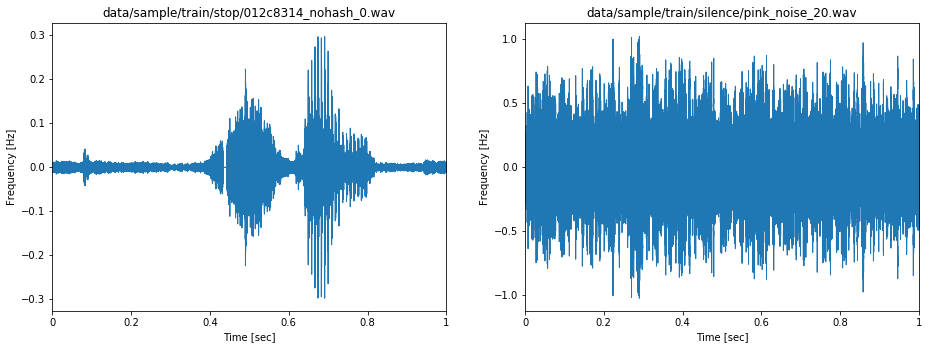

In [14]:
# show our original "stop" and pink noise waveforms:
graph_multiple_waveforms([path_to_stop, path_to_background])

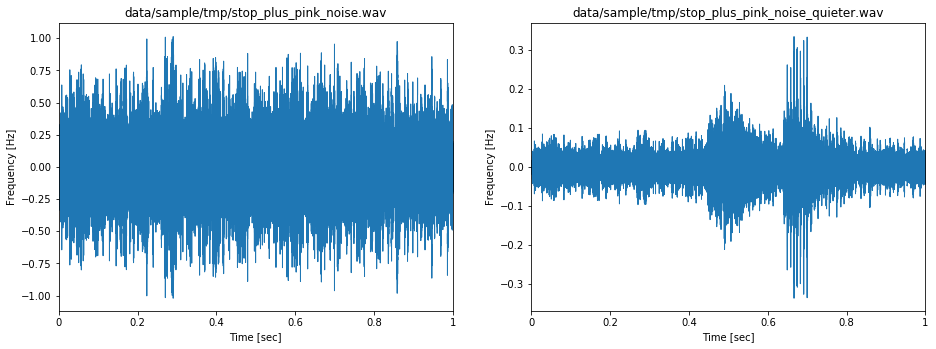

In [15]:
# compare the 2 versions of the mixed files, one without and one with the volume adjustment
graph_multiple_waveforms([path_to_mixed, path_to_mixed_quieter])

### White noise
It's relatively easy to add white noise to a file - we just create a random array of the same length as our original audio file's content and add the two together, keeping the same sampling rate.

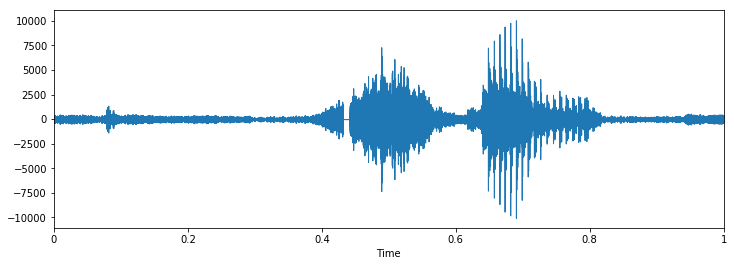

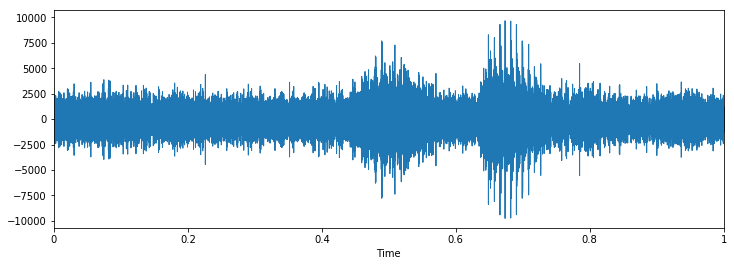

In [16]:
# first get the sampling rate and content of a .wav file
sr, data = get_wav_info(path_to_stop)

# add random white noise
wn = np.random.randn(len(data))
data_wn = data + 1000*wn

# cast to floats (data is currently int16 and data_wn is float64 after having wn added to it)
data = data.astype(np.float64)

graph_waveform_from_data(data, sampling_rate=sr)
graph_waveform_from_data(data_wn, sampling_rate=sr)

We would prefer to use a function for this so let's take advantage of our utils.py again. We can specify the amount of white noise we wish to add, judging by the cell above a white noise multiplication factor of 1000 works well and thus is used as default.

In [17]:
path_to_added_white_noise = os.path.join(path_to_tmp, "stop_with_added_white_noise.wav")
augment_with_white_noise(path_to_stop, path_to_added_white_noise, wn_factor=1000)

'data/sample/tmp/stop_with_added_white_noise.wav'

In [18]:
get_wav_info(path_to_stop)

(16000, array([252., 260., 225., ..., 356., 337., 345.]))

In [19]:
get_wav_info(path_to_added_white_noise)

(16000, array([ 1427.,  1058., -1602., ...,  -752.,  1427.,    12.]))

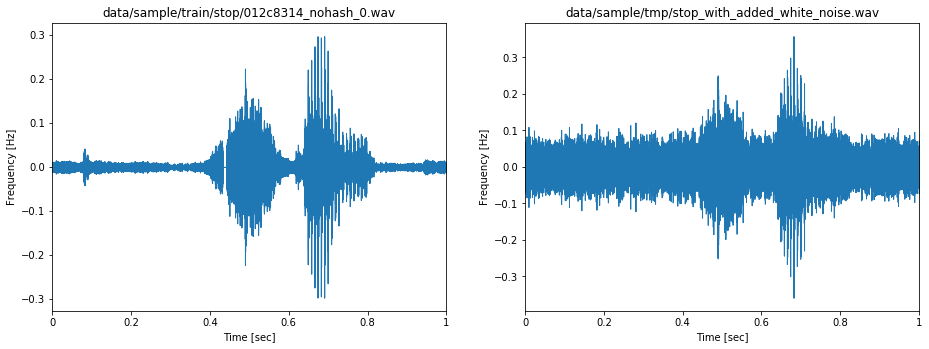

In [20]:
graph_multiple_waveforms([path_to_stop, path_to_added_white_noise])

Looks good, let's listen to the files though:

In [21]:
display_audio(path_to_stop)

In [22]:
display_audio(path_to_added_white_noise)

The word "stop" is a bit more difficult to distinguish in our new version with the randomly generated white noise and that's the reason we kept our wn_factor customizable - if we decrease the amount of white noise we can get a better sample.

In [23]:
# define a new path
path_to_added_white_noise_adjusted = os.path.join(path_to_tmp, "stop_with_added_white_noise_adjusted.wav")

# let's decrease the amount of whitenoise via the wn_factor parameter
augment_with_white_noise(path_to_stop, path_to_added_white_noise_adjusted, wn_factor=200)

display_audio(path_to_added_white_noise_adjusted)

### Shifting
We can also move the actual sound of the utterance forward or backward using numpy's roll() function. We want our model to be insensitive to where the actual utterance starts so it can be very beneficial to take one .wav and create a number of variations, each with a different starting point of the utterance.

When showing how this method works I use the data directly (as numpy array), instead of reaching to a specific wav file. Therefore I'm using the IPython.display.Audio() function for playing the sound within the notebook instead of our display_audio() function from utils.py.

In [24]:
# grab a new wav files
path_to_up = os.path.join(path_to_sample, "train/up/079dfce3_nohash_1.wav")

# obtain sampling rate and data
sr, data = get_wav_info(path_to_up)

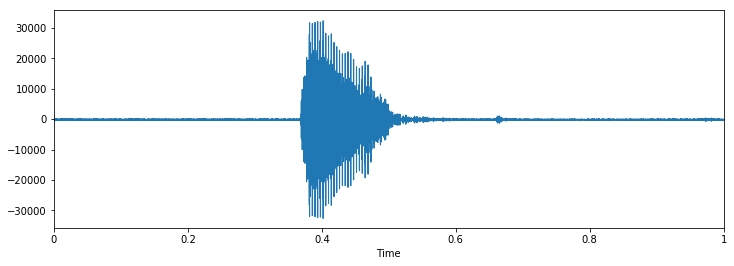

In [25]:
# show original file
graph_waveform_from_data(data, sampling_rate=sr)
ipd.Audio(data, rate=sr)

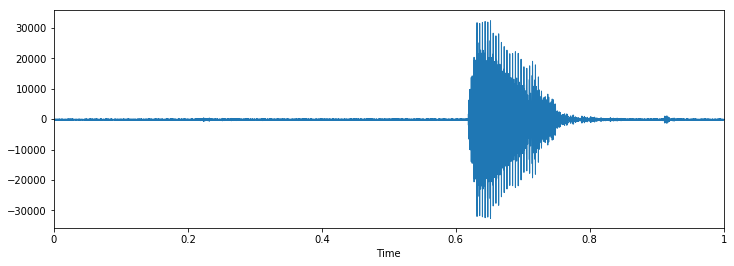

In [26]:
# roll data by 1/4 of sampling rate
data_roll = np.roll(data, sr // 4)
graph_waveform_from_data(data_roll, sampling_rate=sr)
ipd.Audio(data_roll, rate=sr)

We can see that the utterance of the command "up" got shifted significantly towards the end of the file (from 0.2 - 0.4 second mark to 0.5 - 0.7).

When using the roll function of numpy we are risking that we'll shift the end of the utterance all the way back to the beginning of the file, effectively cutting it in half. We could write a function for replacing anything that would get shifted back to the beginning with some value or even generate whitenoise for it but that still doesn't reduce the risk of cutting the utterance to the point of it being unrecognizable.

Therefore we should experiment with shifts before deciding to use them (with an actual model). For now the best solutions is to shift by a relatively small amount, e.g. 1/8th of the sampling rate, hoping that very few utterances end at almost the exact end of the file. We have implemeneted the augment_with_shift() function from our utils in that way.

In [27]:
# define new paths
path_to_shifted_default = os.path.join(path_to_tmp, "up_shifted_by_default.wav")
path_to_shifted_custom = os.path.join(path_to_tmp, "up_shifted_custom.wav")

# augment using the default shift factor and a custom one
augment_with_shift(path_to_up, path_to_shifted_default)
augment_with_shift(path_to_up, path_to_shifted_custom, 8000)

'data/sample/tmp/up_shifted_custom.wav'

In [28]:
type(get_wav_info(path_to_shifted_default))

tuple

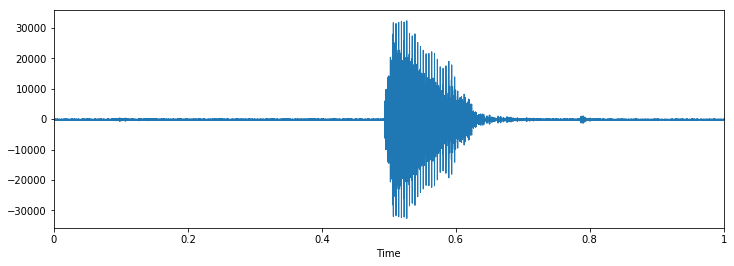

In [29]:
# shift equalt to 1/8 sampling rate
graph_waveform(path_to_shifted_default)
display_audio(path_to_shifted_default)

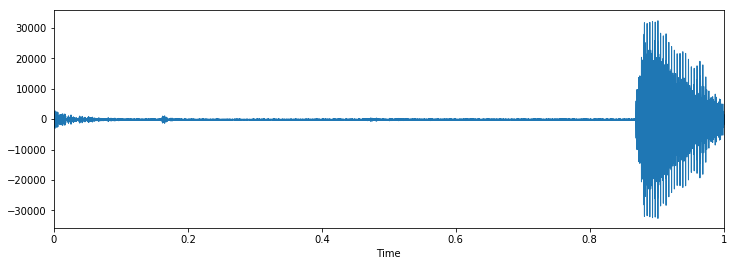

In [30]:
# shift equalt to 8000 (1/2 sampling rate)
graph_waveform(path_to_shifted_custom)
display_audio(path_to_shifted_custom)

### Stretching
We can also try stretching the sound using librosa's effects.time_stretch() function.

In [31]:
# obtain sampling rate and data via librosa's load function to avoid casting error
data, sr = librosa.load(path_to_up)

In [32]:
# stretch the sound by a factor of 1.2
data_stretched = librosa.effects.time_stretch(data, 1.2)

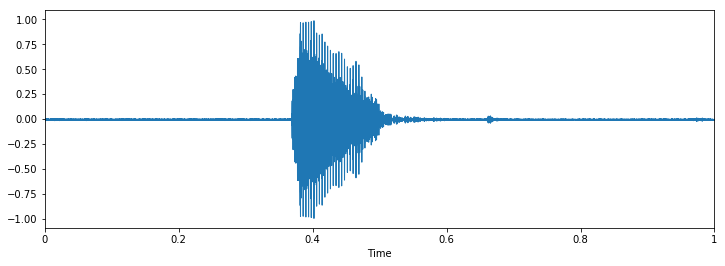

In [33]:
# show the original
graph_waveform_from_data(data, sr)
ipd.Audio(data, rate=sr)

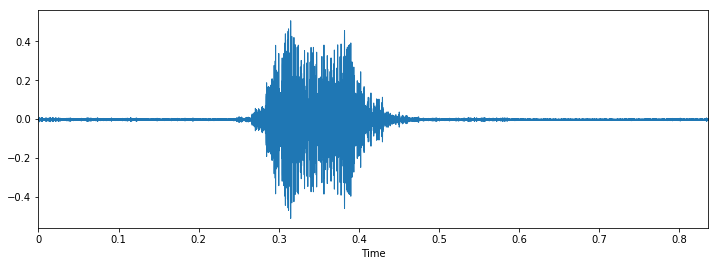

In [34]:
# show the difference
graph_waveform_from_data(data_stretched, sr)
ipd.Audio(data_stretched, rate=sr)

The voice becomes deeper (we've essentially increased the wavelength) but it's still recognizable and different enough from the original to be useful in terms of increasing the amount of valid samples.

However the final decision as to which data augmentation to use should come from experiments - we will only use the techniques that actually increase the efficiency of our models.

### Clean up
Finally let's clean up our tmp directory.

In [35]:
# remove the temporary directory and all its contents
!rm -r $path_to_tmp